# Introduction to Spike Trains

*The examples and code in this chapter were adapted from Chapter 3 of Nylen, E.L., and Wallisch, P.. (2017).* [Neural Data Science](https://www.sciencedirect.com/book/9780128040430/neural-data-science). *Academic Press. by Aaron J. Newman. Code has been modified to be more pythonic and efficient. Explanatory text by Aaron J. Newman.*

## Overview
This is a lesson that introduces **spike trains** — sequences of action potentials: how they can be represented as data, and some ways of working with and visualizing them. As well, it introduces a few new bits of Python syntax and a discussion of the use of colour in scientific visualization. 

## Learning Objectives
Once you've completed this lesson you should be able to:
### Spike trains
- define spike trains
- explain how spike train data is recorded
- describe two ways of storing spike train data: time series and spike times
- interpret raster plots and peri-stimulus time histograms
- generate those two types of visualizations

### Python
- explain what a pickle is in Python, and some advantages and disadvantages of pickling
- use subplots to plot multiple levels of data in a single graphic
- understand and properly use Python's naming convention (snake case) for variable names
- properly use whitespace in formatting your code
- consider the relative benefits of hard-coding values in your code, versus writing snippets of code that derive these values from the data itself
- use nested list comprehension

### Data Visualization
- make informed decisions about accessible design in scientific visualization, including colour map choice and interpolation methods

---
## Spike Trains

As you know, neurons communicate by generating[ action potentials](https://en.wikipedia.org/wiki/Action_potential). Action potentials are also called "spikes", because when they are recorded, they manifest as spikes in the electrical recording - transient changes from a baseline level of voltage to a different level, then a return to baseline. Neurons have a negative resting potential, meaning that their intracellular space has a negative voltage (more negative ions, like chloride) relative to the extracellular space (which has more positive ions, like sodium). When an action potential occurs, ion channels in the neuron's cell wall open, allowing the intracellular space to become more positive. Thus the neuron **depolarizes** when it fires, and its voltage moves closer to zero. The sodium-potassium pumps on the cell wall then re-polarize the neuron to its resting (negative) voltage. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Action_potential.svg/1920px-Action_potential.svg.png" alt="Source: wikimedia.org" width=350px>

Spike trains are recordings of action potentials, from electrodes inserted in the brain. Often these are from **intracellular** recordings, meaning that an electrode penetrated the membrane of a neuron and records its action potentials. In other cases, spike train data may be from **extracellular** recordings, in which the electrode is inserted into the brain but does not penetrate a neuron. Instead, the electrode is located in extracellular space (between cells). In this case, the electrode will likely pick up action potentials from multiple nearby neurons. Extracellular recordings are commonly done with arrays of closely-spaced electrodes, such that multiple electrodes pick up the spiking of each neuron but — based on the proximity of the neurons to the electrodes — each electrode likely picks up action potentials from only a subset of the neurons that another electrode does. A process called **spike sorting** is applied to the data after it is recorded to attempt to identify spikes from different neurons, based on which electrodes detect which spikes. 

Spike train data are *binary* — either a neuron is spiking ("on") or not ("off"). This is distinct from many other types of neural data, such as EEG or fMRI, or even local field potentials recorded from implanted electrodes. A neuron is either firing or not, and each spike is very short in duration. You can make an analogy from this to Boolean types in Python: a Boolean variable is either True (1) or False (0), just as a neuron is either spiking or not. 

Spike data, or "spike trains", ultimately consist of information concerning the times at which spikes occurred. Broadly speaking, there are two forms for this sort of data. In what we'll call the "continuous" form, we have data at every time point over a time period (e.g., a 2 s period covering one trial in an experiment). At each time point, the data is either 0 (no spike) or 1 (spike). In the "discontinuous" form, the data instead are represented as the time points at which spikes occurred. The assumption is that nothing happened, and we only encode "news of a difference" from that assumption. This is a much more efficient way of representing the data, since we don't encode all those time points where nothing happened. But regardless, both are valid ways of representing the data that you'll see in this unit of the course. 

Here's [a great article by neuroscientist Mark Humphries](https://medium.com/the-spike/a-neural-data-science-how-and-why-d7e3969086f2) on spike trains in a data science context, that will give you more background information (thanks to student Meg South for the link!). If you want to understand more about the process and lab techniques involved in recording spikes, there is a great (30 min) [video by Dr. Carl Petersen](https://youtu.be/tInqGXWTD8I).  
This notebook gets you started on the first of the three approaches he talks about; specifically, determining whether there is structure in the data. 

In [14]:
import matplotlib.pyplot as plt
import numpy as np

## Our first spike train

Below we create a list of binary (1 or 0) values. Python lists are ordered, which makes them a good way of storing sequential data like a time series. In the list below, each value represents an evenly-spaced point in time (e.g., one data value every 10 ms), where `0` encodes time points at which no action potential was detected, and `1` represents times when action potentials occurred. 

In [2]:
spike_train = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]

<div class="alert alert-block alert-info">
    <h3>Style note:</h3>
    
Notice that in all variable names, I use all lower case with underscores separating words, as in `spike_train` and, below, `light_onset_time`. This naming convention is called **snake case**, and is actually defined in [Python PEP 8](https://www.python.org/dev/peps/pep-0008/#naming-conventions) (remember, PEPs are the "Python Enhancement Proposals" that provide standards for the language). PEP 8 specifies that regular variables "should be lowercase, with words separated by underscores as necessary to improve readability". 
    
You may encounter different conventions as standard in other programming languages, such as [**camel case**](https://en.wikipedia.org/wiki/Camel_case) which would be `SpikeTrains` or possibly `spikeTrains` (for the aficionados: the first is is a sub-type of camel case called **Pascal case**, while the second is **dromedary case**). However, PEP 8 specifies that camel case should only be used for naming classes and type variables. Don't worry if you don't know what classes and type variables are; the point is that the Python convention is to use lower-case variable names, with words separated by underscores.
    
There is a good reason for following these conventions: when a seasoned Python programmer sees something in camel case, they will expect it to be a class or type variable, not a regular variable. Following Python's conventions thus improves the readability, sharability, and transparency of code.
</div>

## Stimulus locking

In this hypothetical experiment, the neuron in question was genetically engineered for [**optogenetics**](https://en.wikipedia.org/wiki/Optogenetics), meaning that it expresses genes sensitive to a specific wavelength of light (550 nm, which is green). When light of that wavelength is directed at the neuron, it tends to fire. In this experiment, the light was turned on at time point 5 in the spike train data. If you want to learn more about optogenetics, check out [this video by Prof. Carl Petersen](https://youtu.be/lqroI7sFVuk).

The code below defines that light onset time as a variable, and also defines that a spike is represented as a 1 in the data. 

In [3]:
light_onset_time = 5
spike_value = 1

A characteristic feature of a neuron is the *first spike latency to stimulus* — how long after a stimulus the first spike occurs. Different neurons will have different average values of this. The code below finds this value for our data, and assigns it to a variable.

In the first line, we use `light_onset_time:` to search forward in the list of values from the time of the stimulus - since we want to look for the first spike after that stimulus. We add the `.index()` method to find the index of the first instance of `spike_value` (1, when a spike occurred). We then print that value.

In [4]:
latency_to_first_spike = spike_train[light_onset_time:].index(spike_value) 
print('first spike latency to stimulus = ' + str(latency_to_first_spike))

first spike latency to stimulus = 4


If we want to find all the spikes in the spike train, we can use the `enumerate()` function in a for loop. Unlike a regular `for` loop, which simply loops through all values of a list (or other object), `enumerate()` does this while keeping track of the index of the current item within the loop. 

To illustrate, if we use a `for` loop to print the values of `spike_train` we get:

In [5]:
for x in spike_train:
    print(x)

0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
1
0
0
0


If we use the `enumerate()` function, we assign the index of the list to `i`, and the value of the list to `x` (as we did above):

In [6]:
for i, x in enumerate(spike_train):
    print(i, x)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 1
10 0
11 1
12 0
13 1
14 0
15 0
16 0
17 1
18 0
19 0
20 0


You can see the first column is the index (position) in the list, and the second column indicates whether a spike happened or not. 

Based on this, we can use list comprehension to create a list of the time points (indices) where spikes occurred: 

Here we find the time points of all spikes (where `x==1`)in the spike train:

In [7]:
spike_times = [i for i,x in enumerate(spike_train) if x==1]
print(spike_times)

[9, 11, 13, 17]


### List comprehension
The above code uses some elegant Python list comprehension:

`spike_times = [i for i,x in enumerate(spike_train) if x==1]`

Take some time to break this down and understand it — there's a lot going on! Recall that list comprehension is used to create a `for` loop in a single line, and return a list. It's a useful and compact way to iterate over some set of items to get them into a list. The `enumerate()`  enumerates (counts) the items as it goes through a loop, which allows us to retrieve the index of only values matching a certain condition (in this case, spiking).

For a review of list comprehension, check out [this DataCamp tutorial](https://www.datacamp.com/community/tutorials/python-list-comprehension).

---
## Visualizing a Spike Train: Raster Plots

Visualization is a highly effective way of making the data more interpretable. Below we generate a **raster plot**, with time on the *x* axis, and the spikes as vertical lines. The *y* axis is shown as a continuous scale (the default in matplotlib), but of course the actual values can only be 0 or 1. 

One thing to notice in the code for this plot is that it's kind of "hacking" matplotlib functions to generate the plot. That is, we're not passing the data to a standard matplotlib plot class like a bar chart or a histogram. Instead, we use the `matplotlib.pyplot.vlines` function (recall above we imported `matplotlib.pyplot` as `plt`) which will draw a vertical line anywhere on a plot. This is often used for manually drawing a line on top of data. In this case, we pass the `spike_times` list to `plt.vlines` and use this function to actually plot our data. The code below also uses the `axvspan` function to add green shading to the time period during which the green light was on. Note the clever use of colour-coding; rather than using an arbitrary or neutral shading colour like grey, the colour simultaneously encodes the time of the stimulus, and a key property of it. This is effective communication!

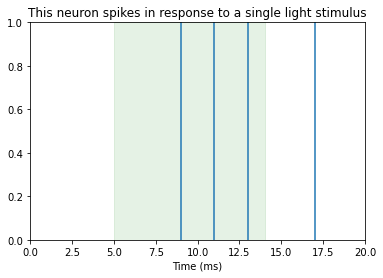

In [8]:
fig = plt.figure()
ax = plt.subplot(111)
plt.vlines(spike_times, 0, 1)
plt.ylim([0, 1])
plt.axvspan(5,14, alpha=0.1, color='g')
plt.xlim([0, 20])
plt.title('This neuron spikes in response to a single light stimulus') 
plt.xlabel('Time (ms)')
plt.show()

## More Trials

Naturally, in a real experiment we would not stimulate a neuron once, record the data, and say the experiment was finished and that the one spike train was representative of what that neuron would do every time it's stimulated. We would want to run repeated trials to identify the consistent properties of the neuron (and likely record from more neurons as well; we'll come to that in the next notebook).

Below we create 10 spike trains, representing 10 trials. These are stored as a list of lists, as we can tell from square brackets embedded in square brackets: 

In [9]:
ten_spike_trains = [[0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0],
                  [1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0],
                  [0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0]
                 ]

Although the nicely-formatted list of lists above is pretty easy to look at and see where spikes occur, a graph will definitely be a more effective way of communicating this information, because we can add details that aid in interpretation, such as a time axis, shading to indicate when the light is on, axis labels, and a title. 

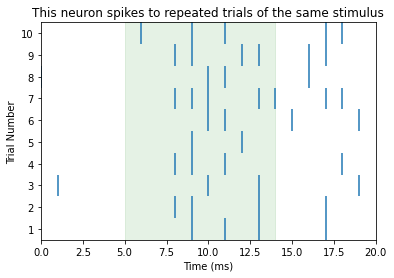

In [10]:
# Create an empty figure
fig = plt.figure()
ax = plt.subplot(1,1,1)

# Do the plotting
for trial in range(len(ten_spike_trains)):
    spike_times = [i for i, x in enumerate(ten_spike_trains[trial]) if x==1]
    plt.vlines(spike_times, trial, trial+1)

# Make it pretty
plt.axvspan(5, 14, alpha=0.1, color='g')
plt.xlim([0, 20])
plt.ylim([0, 10])
plt.title('This neuron spikes to repeated trials of the same stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Trial Number')
plt.yticks([x + 0.5 for x in \
            range(10)],[str(x + 1) for x in \
                        range(10)])

plt.show()

Note in the plot command above how each trial is drawn as a separate row in the graph, again using `plt.vlines()`, but embedded in a loop through each list (trial) within `ten_spike_trains`. The [API](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.vlines.html) for `plt.vlines()` shows that the first three arguments are: `vlines(x, ymin, ymax)`, where `ymin` and `ymax` define the bottom and top range of the vertical line. The trial number (`trial`, which is iterated over in the `for` loop) is used as `ymin` and the next trial number (`trial+1`) as `ymax`. This is in contrast to the first raster plot (for one trial), where `ymin` and `ymax` were set to `0` and `1`, respectively, to span the whole *y* axis.

## The Peri-Stimulus Time Histogram (PSTH)

Along with raster plots, another common way of visualizing spike train data is the *peri-stimulus time histogram* (PSTH). As the name implies, this is a histogram — a plot of the count of spikes at each time point in the spike trains. PSTHs are a useful tool in aggregating the data across trials. As biological entities, neurons are complex and do not always spike at exactly the same time, or rate, every time they are stimulated. This is why we collect data over many trials — to identify the average pattern of responding. By summing the number of spikes at each time point, PSTHs allow us to visualize when the neuron is most likely to spike.

The code below uses `plt.subplot` to nicely combine the raster and PSTH in one figure, which allows us to see the data in both representations. This is helpful because we can see the raw data (raster) and the aggregated version (PSTH).

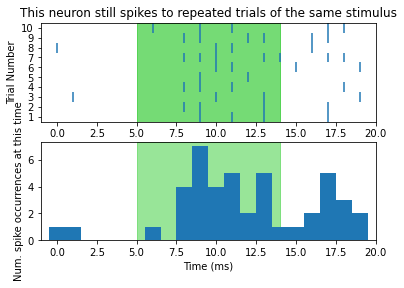

In [11]:
fig = plt.figure()

# Define that the figure has subplots, arranged as 2 rows (the first number) 
#   and 1 column (second number), and that the next commands will draw into 
#  the first subplot (the third number):
ax = plt.subplot(211)

# Put the raster plot in the first (top) subplot. 
# This is essentially the same as the code for the previous raster plot, above
for trial in range(len(ten_spike_trains)): 
    spike_times = [i for i, x in enumerate(ten_spike_trains[trial]) if x==1] 
    plt.vlines(spike_times, trial, trial+1) 
    plt.axvspan(5, 14, alpha=0.1, color='limegreen') 
    plt.ylim([0, 10])
plt.title('This neuron still spikes to repeated trials of the same stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Trial Number')
plt.yticks([x + 0.5 for x in range(10)], [str(x + 1) for x in range(10)])
plt.xlim([-1, 20])

# Now draw into the second subplot, again specifying that overall the figure has 2 rows and 1 column
ax = plt.subplot(212)

# Draw the PSTH
plt.axvspan(5, 14, alpha=0.5, color='limegreen')
ax.bar(range(21), np.sum(ten_spike_trains, 0), 1)
plt.xlabel('Time (ms)')
plt.ylabel('Num. spike occurrences at this time')
plt.xlim([-1, 20])
plt.show()

The above PSTH simply plots the number of spikes per time bin (using the `np.sum()` function). Thus the numbers plotted are somewhat arbitrary, in that they will differ depending on the number of trials that were run. As well, even when we see peaks in the histogram, if we visualize the raw count without knowing the number of trials that contributed, we don't have a good way of interpreting the data. That is, since we know here that we have 10 trials, a count of 7 is a high proportion of trials. However, if the data comprised 25 trials, a peak of 7 would likely not be compelling evidence that the neuron was responsive to the stimulus. We should always strive for transparency and readability in visualizing data, and minimize the need for the viewer to read additional material (e.g., the methods section where hopefully the number of trials is reported) to interpret the plot. As well, plotting things in standardized units makes it easier to compare across plots, articles, etc.. 

In the case of PSTHs, what we really want to know is how *probable* is it that the neuron will fire at a particular time point after a stimulus, across trials. We can do this by simply computing the mean number of spikes at each time point. Since the only possible values are 0 or 1, the mean will represent the proportion of times that the neuron spiked at that time point, regardless of how many trials comprised the data.

We might also want to get a sense, visually, of whether the probability of firing is greater than chance, and thus related to the stimulus. Since the neuron only has two possible states (firing or not), a simple criterion would be to say that if the neuron fires on more than 50% of trials, it is responding to the stimulus. We can facilitate this interpretation for our viewer by adding a horizontal dashed line at 0.5 on the *y* axis, using `plt.axhline()`:

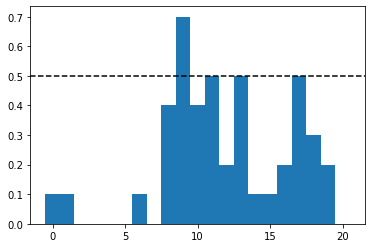

In [12]:
fig = plt.figure()
plt.bar(range(21), np.mean(ten_spike_trains, 0), 1)
plt.axhline(y=0.5, xmin=0, xmax=20, linestyle='--', color='k')
plt.show()

We can add further details to the plot to enhance interpretation even more:

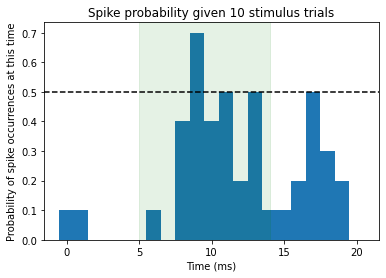

In [13]:
fig = plt.figure() 
plt.bar(range(21), np.mean(ten_spike_trains, 0), 1)
plt.axhline(y=0.5, xmin=0, xmax=20, linestyle='--', color='k')

# add shading
plt.axvspan(5, 14, alpha=0.1, color='g') 

# add some labels
plt.title('Spike probability given 10 stimulus trials')
plt.xlabel('Time (ms)')
plt.ylabel('Probability of spike occurrences at this time')
plt.show()